# RSE SkillShare day Keras Tutorial

Getting to grips with Keras for predicting binding motifs for DNA or RNA binding proteins.

Useful references:

[Predicting the sequence specificities of DNA- and RNA-binding proteins by deep learning, Alipanahi et al., 2015](https://www.nature.com/articles/nbt.3300)

env: KERAS_BACKEND=tensorflow


Using TensorFlow backend.


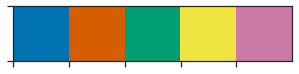

In [1]:
import sys
import os
from glob import glob
import random
from collections import Counter
from pprint import pprint

import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

import h5py

%env KERAS_BACKEND tensorflow
import tensorflow as tf
from keras import (
    models, layers, activations,
    optimizers, losses, callbacks
)
import keras.backend as K

from sklearn.metrics import (
    roc_curve, precision_recall_curve, roc_auc_score
)
from sklearn.model_selection import KFold, train_test_split
from sklearn.utils import shuffle


## Default plotting params

%matplotlib inline
sns.set(font='Arial')
plt.rcParams['svg.fonttype'] = 'none'
style = sns.axes_style('white')
style.update(sns.axes_style('ticks'))
style['xtick.major.size'] = 2
style['ytick.major.size'] = 2
sns.set(font_scale=2, style=style)
pal = sns.color_palette(['#0072b2', '#d55e00', '#009e73', '#f0e442', '#cc79a7'])
cmap = ListedColormap(pal.as_hex())
sns.set_palette(pal)
sns.palplot(pal)
plt.show()

In [2]:
%%bash
URL="http://hgdownload.cse.ucsc.edu/goldenPath/hg19/encodeDCC/wgEncodeAwgTfbsUniform/wgEncodeAwgTfbsBroadHsmmCtcfUniPk.narrowPeak.gz"
wget -O - $URL > ../data/ctcf.narrowPeak.gz

--2019-05-23 17:59:33--  http://hgdownload.cse.ucsc.edu/goldenPath/hg19/encodeDCC/wgEncodeAwgTfbsUniform/wgEncodeAwgTfbsBroadHsmmCtcfUniPk.narrowPeak.gz
Resolving hgdownload.cse.ucsc.edu (hgdownload.cse.ucsc.edu)... 128.114.119.163
Connecting to hgdownload.cse.ucsc.edu (hgdownload.cse.ucsc.edu)|128.114.119.163|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1080963 (1.0M) [application/x-gzip]
Saving to: ‘STDOUT’

     0K .......... .......... .......... .......... ..........  4%  154K 7s
    50K .......... .......... .......... .......... ..........  9%  304K 5s
   100K .......... .......... .......... .......... .......... 14% 4.57M 3s
   150K .......... .......... .......... .......... .......... 18% 1.67M 2s
   200K .......... .......... .......... .......... .......... 23%  350K 2s
   250K .......... .......... .......... .......... .......... 28% 4.80M 2s
   300K .......... .......... .......... .......... .......... 33% 4.78M 1s
   350K .......... .......

We have a ChIP-seq dataset for the DNA binding protein CTCF in a human cell line, taken from the ENCODE Uniform Peaks of Transcription Factor ChIP-seq project. We would like to build a model to predict the binding motif of CTCF in new sequences and interpret what the sequence motif might be. We could use a motif discovery and prediction toolkit such as the MEME suite to do this, but of course we want to be fancy and use neural networks. So, where to start?

Data preprocessing is key! First we need to convert our protein binding sites from interval data (narrowPeak format) to sequences. But there are a lot of things to consider....

* **What will our negative training examples be?** To train a model we need both positive examples (sequences which are detected in the ChIPseq dataset) and negative examples (???). So what do we use for negative examples? We could randomly shuffle the intervals through the genome and use this to extract negative sequences, but this might give us a biased set if our positive examples are from specific regions of the genome (the human genome is mostly intergenic and these regions have different sequence compositions to intragenic regions). We could control for this in the shuffling, e.g. if our protein binds in open chromatin, we could randomly shuffle our intervals within open chromatin regions... Another solution that is often used is to randomly shuffle the sequences of the positive training set, but keeping the nucleotide and dinuclotide frequencies of each sequence constant. This provides a background set with similar properties to the positive set, but with higher order patterns in the sequences randomised.
* **How should we process our input data?** Most machine learning models require uniform features as input, but our ChIPseq peaks are all different lengths! One way to address this could be to extract features such as trinucleotide frequencies from the sequences, but this is lossy and kind of defeats the purpose of using a more complex model like a neural net. Because the narrowPeak format contains a single base "summit" which is the middle of the peak, we could also extract a fixed length window centered on this summit.
* **How should we encode our input data?** Sequence data is categorical (the categories being A, C, G, or T) but Keras models do not understand categorical input. We can therefore use "dummy" variables to encode our sequence as a Nx4 binary matrix.
* **Can we augment our input data?** Data augmentation can be useful to artificially inflate the amount of training data and prevent the model from overfitting. Examples of augmentation include rotations, skews or reflections applied to images, or random noise applied to continuous variables. It is harder to augment categorical data, but one thing we can do with the ChIPseq data is apply reverse complementation, as the ChIP peaks are unstranded.

### Preprocessing:

Lets start our training data preprocessing... we already have peaks from the CTCF ChIPseq dataset in narrowpeak format, but are they all the same length...?

In [4]:
%%bash
zcat ../data/ctcf.narrowPeak.gz |
column -t | head

chr8   9688475    9688823    .  1000  .  489.520736189029  -1  4.86944881270321  175
chr2   44706566   44706891   .  1000  .  463.303634455582  -1  4.86944881270321  162
chr14  50328795   50329107   .  1000  .  457.13622705226   -1  4.86944881270321  150
chr3   195577775  195578075  .  1000  .  443.446478457079  -1  4.86944881270321  147
chr10  4891878    4892180    .  1000  .  441.230168528308  -1  4.86944881270321  152
chr6   53036680   53037004   .  1000  .  435.377539666658  -1  4.86944881270321  168
chr12  58299164   58299444   .  1000  .  434.464932543491  -1  4.86944881270321  146
chr9   135897772  135898061  .  1000  .  432.489837817086  -1  4.86944881270321  139
chr1   150951995  150952284  .  1000  .  423.025977540522  -1  4.86944881270321  148
chr17  41560977   41561313   .  1000  .  419.532580168275  -1  4.86944881270321  178


In [5]:
%%bash
zcat ../data/ctcf.narrowPeak.gz | wc -l

50924


[(290, 29179),
 (196, 241),
 (202, 238),
 (198, 227),
 (203, 225),
 (214, 219),
 (201, 218),
 (192, 217),
 (195, 216),
 (207, 215)]


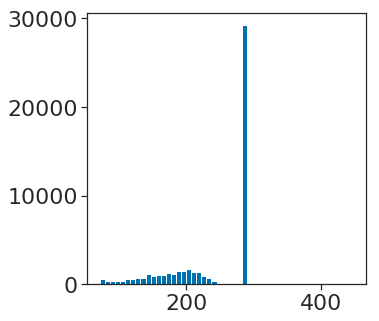

In [6]:
peaks = pd.read_csv(
    '../data/ctcf.narrowPeak.gz',
    sep='\t',
    names=['chrom', 'start', 'end', 'name', 'score', 'strand',
           'signal_value', 'p_value', 'q_value', 'summit'],
    na_values=['.', '-1']
)
peaks['peak_length'] = peaks.end - peaks.start
pprint(Counter(peaks.peak_length).most_common(10))

fig, ax = plt.subplots(figsize=(5, 5))
ax.hist(peaks.peak_length, bins=50)
plt.show()

Most of the peaks seem to be 290 nt long but there are also quite a few shorter ones. Perhaps we should try using a 124 nt window centred on the summit to start with...

In [7]:
%%bash
zcat ../data/ctcf.narrowPeak.gz |
awk -v OFS='\t' '{print $1, $2 + $10 - 64, $2 + $10 + 64}' | \
sort -k1,1 -k2,2n > ../data/ctcf_summit_centred_peaks.bed
column -t ../data/ctcf_summit_centred_peaks.bed | head

chr1   237690     237818
chr1   521520     521648
chr1   714187     714315
chr1   785888     786016
chr1   805233     805361
chr1   840078     840206
chr1   848334     848462
chr1   856515     856643
chr1   873625     873753
chr1   886894     887022


Now we can use bedtools to extract the sequences for these intervals from the hg19 genome:

In [10]:
%%bash
# Also remove any softmasking
bedtools getfasta -tab -fi ../data/hg19.fa -fo stdout -bed ../data/ctcf_summit_centred_peaks.bed | 
tr '[a-z]' '[A-Z]' > ../data/ctcf_summit_centred_seqs.fa

In [2]:
positive_training_examples = pd.read_csv(
    '../data/ctcf_summit_centred_seqs.fa',
    sep='\t',
    names=['inv', 'seq']
)
positive_training_examples['label'] = 1
positive_training_examples.head()

,inv,seq,label
0,CHR1:237690-237818,CCACAGATGTGAAGCTGAGGCTGAAGGAGACTGATGTGGTTTCTCC...,1
1,CHR1:521520-521648,CAGTTTCTCTGTGCGGCACCAGGTGGCAGCAGAGGTCAGCAAGGCA...,1
2,CHR1:714187-714315,TACTGGTGGCCGGGCGGGATGTAACCGGCTGCTGAGCTGGCAGTTC...,1
3,CHR1:785888-786016,ACAAAGTGTCCAAGTGGGATTTTCCTGCTATTTCAAGGACTGCTGC...,1
4,CHR1:805233-805361,GAAGGAGCTTCGCGCTGCCGCCTGGCTGGGGACTGGGCACGCCCTC...,1


Now we need to create our negative training set, which will be a set of shuffled sequences each with identical dinucleotide frequency to a positive example. To do this we can use a nice tool called ushuffle:

In [3]:
def kmer_freqs(seq, k=2):
    return Counter([seq[i:i+k] for i in range(len(seq) - k + 1)])

seq = 'TTTACACGTGATTT'
kmer_freqs(seq)

Counter({'TT': 4,
         'TA': 1,
         'AC': 2,
         'CA': 1,
         'CG': 1,
         'GT': 1,
         'TG': 1,
         'GA': 1,
         'AT': 1})

In [5]:
from ushuffle import shuffle as ushuffle

def ushuffle_str(seq, k):
    shuf = ushuffle(seq.encode(), k)
    return shuf.decode()

shuffled = ushuffle_str(seq, 2)
print(seq, shuffled)

assert kmer_freqs(seq) == kmer_freqs(shuffled)

TTTACACGTGATTT TTTACATGACGTTT


In [6]:
negative_training_examples = []
for seq in positive_training_examples.seq:
    negative_training_examples.append([None, ushuffle_str(seq, 2), 0])
negative_training_examples = pd.DataFrame(
    negative_training_examples, columns=['inv', 'seq', 'label'])
negative_training_examples.head()

,inv,seq,label
0,None,CCGGGGGTGCAAGCCAGCCCACAAGCCCTAGGAGCTGAGAAGCGGA...,0
1,None,CTCAGTGGGGAGCATCGATTGTCGGCCAGGACTTTCTGCAAAGTCT...,0
2,None,TCACGACCGCAGCGCTAGGGCAACCTTGGGCGCCGCTTGCTATTGC...,0
3,None,AGTGCTGCACCCAGATTTTTGCTTCCTTCTAGTGACTGTCATCAAG...,0
4,None,GGGGCCGTGGCGTGGAACCCGAGGCTGCTCCGTGCAGCCAGGCGAG...,0


In [7]:
training_examples = pd.concat(
    [negative_training_examples, positive_training_examples]
).sample(frac=1)
training_examples.head()

,inv,seq,label
38169,CHR5:115911862-115911990,ACCACCTGGAAAAGGTAGGGAGAATGGTAGGAAAAAAAGAAAAAAT...,1
45175,None,CTGGGGAATCTCACAGTGTTTGGTTAACCCAGCTGGGACATACAGC...,0
26751,CHR2:180305491-180305619,CTAAAATATTAAGGTCAACAATTTTCAGTTGGATAAACTCAAAGAG...,1
20551,CHR17:67565287-67565415,GTTTGAATTGGAAAATTTTAATCCAGGTTATAAATCACTTGAGAGA...,1
32698,None,GCACCCTACGGTTGAGGACACCTCCATTGACCCTCCCACTTGCTCT...,0


Ok, now that we have positive and negative training examples, we need to encode them using dummy variables:

In [8]:
SEQ_OHE = {'A': [1, 0, 0, 0],
           'C': [0, 1, 0, 0],
           'G': [0, 0, 1, 0],
           'T': [0, 0, 0, 1],
           'N': [0, 0, 0, 0]}


def one_hot_sequence(seq):
    ohe = []
    for base in seq:
        try:
            ohe.append(SEQ_OHE[base])
        except KeyError:
            ohe.append(SEQ_OHE['N'])
    return np.array(ohe)

pprint(one_hot_sequence('CACGTGN'))

array([[0, 1, 0, 0],
       [1, 0, 0, 0],
       [0, 1, 0, 0],
       [0, 0, 1, 0],
       [0, 0, 0, 1],
       [0, 0, 1, 0],
       [0, 0, 0, 0]])


In [29]:
X_data = np.array([
    one_hot_sequence(seq) for seq in training_examples.seq
])
y_data = training_examples.label.values.astype(np.uint).reshape(-1, 1)

print(X_data.shape, y_data.shape)

(101848, 128, 4) (101848, 1)


We have training data! When training the model it is important to have a hold out test set which is used to evaluate the performance of the model and make sure it is not overfitting. The best practice would be to split the data a number of times and train multiple models on different splits (cross validation) however in the interest of time we are not going to do this today...

In [30]:
# we can use some of the helper functions from sklearn to do our splitting
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.25)
print(X_train.shape, X_test.shape)

(76386, 128, 4) (25462, 128, 4)


### Training:

OK, now lets try fitting some models!

Before we start I should quickly point out some of the important terms... The Keras library is layed out nicely in modules using these terms:

* `models`: Wrapper classes such as `Sequential` or `Model` are in the `models` module and represent the high level model. Useful methods include `compile`, `fit`, `predict`, and `summary`.
* `layers`: A single layer of the neural network. The number of units for the layer can be specificied at instantiation. Layers are stacked by consecutive addition to a `Sequential` model or by being called on the previous layer using the functional API. Not all layers have weights and can be trained. Layer types include:
  * `Dense`: A fully connected layer
  * `Conv1D` or `Conv2D`: A convolutional layer in one or two dimensions
  * `LSTM`: Long short term memory Recurrent layer
  * `MaxPooling1D` or `MaxPooling2D`: A downsampling layer using the max function. Has no weights.
  * `Flatten`, `Add`, `Concatenate`: Operation layers that alter the shape of a tensor or merge two or more tensors together using a specific function.
  * `Dropout`: A "regularisation" layer that turns off certain input weights during training. This helps to prevent overfitting.
* `activations`: Functions which are applied to the output of a layer. For example:
  * `relu`: Rectified Linear Unit, performs max(x, 0) operation. Often used between dense or convolutional layers.
  * `sigmoid`: Sigmoid function, squishes input between 0 and 1. Used for final layer in binary classification problems.
  * `softmax`: Equivalent of sigmoid for multiclass classification problems, creates a probablity for each class such that the sum of the probabilities is equal to 1.
* `losses`: Function which evaluates the performance of the model on the training and validation data. Examples include `binary_crossentropy` (for two-class classification problems), `categorical_crossentropy` (for multi-class classification problems) and `mean_squared_error` (for regression problems).
* `optimizers`: Algorithms which update the parameters of the model in order to minimize the output of the loss function on the training data. Examples include `SGD` (Stochastic Gradient Descent), `Adam`, `Adadelta`, and `RMSprop` (look them up!). Most important parameter of these is the learning rate `lr`.
* `callbacks`: Utilities which perform some function at the end of each epoch, such as finishing training early if the validation loss has stopped decreasing, or saving a model checkpoint.

We can start with a simple multi-layer perceptron (densely connected model). These are not the best for sequence data because they are not position/translation invariant (i.e. if the sequence feature of interest starts at different positions in different training examples it might not be recognised correctly).

In [31]:
# Keras has two model building APIs. For simple models where all layers are
# stacked consecutively the Sequential API is suitable

mlp = models.Sequential()

# layers are added to the model and are automatically stacked up sequentially.
# The first and last layers are automatically used as the input/output
mlp.add(layers.Dense(units=128, activation='relu', input_shape=(128, 4)))
mlp.add(layers.Dense(units=128, activation='relu'))
mlp.add(layers.Dense(units=64, activation='relu'))
mlp.add(layers.Flatten())
# we can use a Dropout layer to prevent outfitting during training
mlp.add(layers.Dropout(rate=0.5))

mlp.add(layers.Dense(32, activation='relu'))
mlp.add(layers.Dense(units=1, activation='sigmoid'))

mlp.compile(
    optimizer='adam', # The algorithm used to fit the model to the data
    loss='binary_crossentropy' # How the performance of the model is evaluated
)

mlp.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_19 (Dense)             (None, 128, 128)          640       
_________________________________________________________________
dense_20 (Dense)             (None, 128, 128)          16512     
_________________________________________________________________
dense_21 (Dense)             (None, 128, 64)           8256      
_________________________________________________________________
flatten_3 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 8192)              0         
_________________________________________________________________
dense_22 (Dense)             (None, 32)                262176    
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 33        
Total para

In [32]:
es = callbacks.EarlyStopping(min_delta=0.005, patience=3, verbose=1)

mlp.fit(
    X_train, y_train,
    validation_split=0.1, # use 10% of the training data for validation at the end of each epoch
    epochs=100, # training is split up into epochs, each training example is used once per epoch
    batch_size=128, # epochs are split up into minibatches, this determines batch size
                    # smaller batch sizes should converge in fewer epochs, but training is slower (less parallelised)
    verbose=2,
    callbacks=[es,] # early stopping halts training if validation loss is no longer reducing
)

Train on 68747 samples, validate on 7639 samples
Epoch 1/100
 - 14s - loss: 0.6477 - val_loss: 0.6290
Epoch 2/100
 - 13s - loss: 0.6325 - val_loss: 0.6267
Epoch 3/100
 - 13s - loss: 0.6261 - val_loss: 0.6185
Epoch 4/100
 - 13s - loss: 0.6144 - val_loss: 0.6151
Epoch 5/100
 - 13s - loss: 0.5967 - val_loss: 0.5860
Epoch 6/100
 - 13s - loss: 0.5819 - val_loss: 0.5766
Epoch 7/100
 - 13s - loss: 0.5717 - val_loss: 0.5752
Epoch 8/100
 - 13s - loss: 0.5641 - val_loss: 0.5666
Epoch 9/100
 - 13s - loss: 0.5550 - val_loss: 0.5623
Epoch 10/100
 - 14s - loss: 0.5527 - val_loss: 0.5611
Epoch 11/100
 - 14s - loss: 0.5485 - val_loss: 0.5558
Epoch 12/100
 - 14s - loss: 0.5438 - val_loss: 0.5629
Epoch 13/100
 - 14s - loss: 0.5423 - val_loss: 0.5682
Epoch 14/100
 - 14s - loss: 0.5394 - val_loss: 0.5636
Epoch 00014: early stopping


We can evaluate the performance of the model on the test data using a Receiver Operator Characteristic curve:

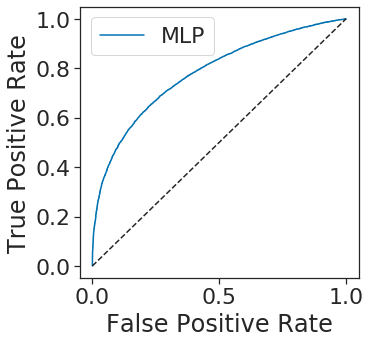

In [33]:
RESULTS = {}

def evaluate_model(model, model_name, X_test, y_test):
    y_pred = model.predict(X_test)
    # ROC curve function from sklearn.metrics
    fpr, tpr, thresh = roc_curve(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred)
    RESULTS[model_name] = {
        'fpr': fpr, 'tpr': tpr, 'auc': auc, 'model': model
    }
    
    fig, ax = plt.subplots(figsize=(5, 5))
    for model_name in RESULTS:
        ax.plot(
            RESULTS[model_name]['fpr'],
            RESULTS[model_name]['tpr'],
            label=model_name
        )
    ax.plot([0, 1], [0, 1], ls='--', color='#252525')
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.legend()
    plt.show()

evaluate_model(mlp, 'MLP', X_test, y_test)

Lets try a recurrent neural network. In terms of the amount of code required RNNs seem very simple! But the Keras implementation is a bit slow on CPU

In [34]:
# The other Keras model API is functional. Each layer
# object is callable. It can be called on another layer
# to connect them:

input_layer = layers.Input(shape=(128, 4))
# Bidirectional wrapper creates two LSTMs that run in opposite directions along the sequence
prev = layers.Bidirectional(layers.LSTM(8))(input_layer)
prev = layers.Dense(32, activation='relu')(prev)
prev = layers.Dropout(rate=0.5)(prev)
output_layer = layers.Dense(1, activation='sigmoid')(prev)

# Once we have our layers we create a model specifying the
# input and the output. If we want a multi-input or 
# mult-output model we could pass a list of several layers.
lstm = models.Model(input_layer, output_layer)

lstm.compile(
    optimizer=optimizers.RMSprop(lr=1e-3), # RMSprop is generally a better optimiser for RNN
    loss='binary_crossentropy'
)
lstm.build((None, 128, 4))
lstm.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 128, 4)            0         
_________________________________________________________________
bidirectional_5 (Bidirection (None, 16)                832       
_________________________________________________________________
dense_24 (Dense)             (None, 32)                544       
_________________________________________________________________
dropout_8 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_25 (Dense)             (None, 1)                 33        
Total params: 1,409
Trainable params: 1,409
Non-trainable params: 0
_________________________________________________________________


Note that this model has a lot fewer parameters than the previous densely connected model but because of the more complex LSTM layer should perform just as well or better

In [35]:
es = callbacks.EarlyStopping(min_delta=0.005, patience=5, verbose=1)

# Learning rate decay reduces learning rate when the loss function stops going down:
lrd = callbacks.ReduceLROnPlateau(
    min_delta=0.005, factor=0.1, patience=3, verbose=1)

lstm.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=100,
    batch_size=64,
    verbose=2,
    callbacks=[es, lrd]
)

Train on 68747 samples, validate on 7639 samples
Epoch 1/100
 - 104s - loss: 0.6865 - val_loss: 0.6673
Epoch 2/100
 - 101s - loss: 0.6513 - val_loss: 0.6887
Epoch 3/100
 - 101s - loss: 0.6329 - val_loss: 0.6293
Epoch 4/100
 - 101s - loss: 0.6255 - val_loss: 0.6435
Epoch 5/100
 - 100s - loss: 0.6202 - val_loss: 0.6216
Epoch 6/100
 - 99s - loss: 0.6146 - val_loss: 0.6179
Epoch 7/100
 - 99s - loss: 0.6074 - val_loss: 0.6114
Epoch 8/100
 - 99s - loss: 0.6033 - val_loss: 0.6596
Epoch 9/100
 - 99s - loss: 0.5998 - val_loss: 0.5855
Epoch 10/100
 - 99s - loss: 0.5930 - val_loss: 0.6037
Epoch 11/100
 - 99s - loss: 0.5879 - val_loss: 0.5764
Epoch 12/100
 - 99s - loss: 0.5812 - val_loss: 0.6307
Epoch 13/100
 - 99s - loss: 0.5746 - val_loss: 0.5694
Epoch 14/100
 - 99s - loss: 0.5689 - val_loss: 0.5715
Epoch 15/100
 - 99s - loss: 0.5627 - val_loss: 0.5613
Epoch 16/100
 - 99s - loss: 0.5572 - val_loss: 0.5617
Epoch 17/100
 - 99s - loss: 0.5507 - val_loss: 0.5542
Epoch 18/100
 - 99s - loss: 0.5432 - 

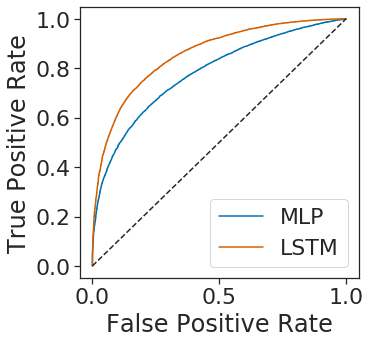

In [36]:
evaluate_model(lstm, 'LSTM', X_test, y_test)

We can also try a mixed convolutional/recurrent architechture. This has been used with some success on biological data [(Quang et al. 2016)](https://www.ncbi.nlm.nih.gov/pubmed/27084946) as it can identify short range features with the conv layers and longer range features with the RNN.

In [40]:
conv_lstm = models.Sequential()
conv_lstm.add(layers.Conv1D(8, kernel_size=3, padding='same', input_shape=(128, 4)))
conv_lstm.add(layers.Conv1D(8, kernel_size=3, padding='same'))
conv_lstm.add(layers.MaxPooling1D(pool_size=2)) # Max pooling layer downsamples input by half
                                                # using the max function.
                                                # sort of equivalent to x.reshape(-1, 2).max(1)
conv_lstm.add(
    layers.Bidirectional(layers.LSTM(8))
)
conv_lstm.add(layers.Dense(units=32, activation='relu'))
conv_lstm.add(layers.Dropout(rate=0.5))
conv_lstm.add(layers.Dense(units=1, activation='sigmoid'))

conv_lstm.compile(
    optimizer=optimizers.RMSprop(lr=1e-3), # RMSprop is a better optimiser for RNN
    loss='binary_crossentropy'
)
conv_lstm.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_4 (Conv1D)            (None, 128, 8)            104       
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 128, 8)            200       
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 64, 8)             0         
_________________________________________________________________
bidirectional_7 (Bidirection (None, 16)                1088      
_________________________________________________________________
dense_28 (Dense)             (None, 32)                544       
_________________________________________________________________
dropout_10 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_29 (Dense)             (None, 1)                 33        
Total para

In [41]:
es = callbacks.EarlyStopping(min_delta=0.005, patience=5, verbose=1)
lrd = callbacks.ReduceLROnPlateau(
    min_delta=0.005, factor=0.1, patience=3, verbose=1)

conv_lstm.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=100,
    batch_size=64,
    verbose=2,
    callbacks=[es, lrd]
)

Train on 68747 samples, validate on 7639 samples
Epoch 1/100
 - 56s - loss: 0.6860 - val_loss: 0.6790
Epoch 2/100
 - 54s - loss: 0.6386 - val_loss: 0.5981
Epoch 3/100
 - 54s - loss: 0.5731 - val_loss: 0.5356
Epoch 4/100
 - 54s - loss: 0.5140 - val_loss: 0.5196
Epoch 5/100
 - 54s - loss: 0.4809 - val_loss: 0.4554
Epoch 6/100
 - 54s - loss: 0.4603 - val_loss: 0.4395
Epoch 7/100
 - 54s - loss: 0.4426 - val_loss: 0.4763
Epoch 8/100
 - 54s - loss: 0.4271 - val_loss: 0.4196
Epoch 9/100
 - 54s - loss: 0.4117 - val_loss: 0.4164
Epoch 10/100
 - 54s - loss: 0.3987 - val_loss: 0.4303
Epoch 11/100
 - 54s - loss: 0.3871 - val_loss: 0.4082
Epoch 12/100
 - 54s - loss: 0.3770 - val_loss: 0.3726
Epoch 13/100
 - 54s - loss: 0.3686 - val_loss: 0.3698
Epoch 14/100
 - 54s - loss: 0.3632 - val_loss: 0.4646
Epoch 15/100
 - 54s - loss: 0.3559 - val_loss: 0.4071

Epoch 00015: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 16/100
 - 54s - loss: 0.3382 - val_loss: 0.3569
Epoch 17/100
 

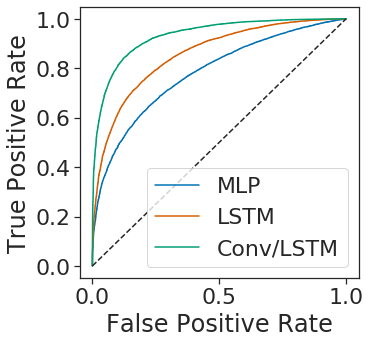

In [42]:
evaluate_model(conv_lstm, 'Conv/LSTM', X_test, y_test)

Finally, lets try a few fully convolutional networks. Not only have I found these to perform better on sequence data, they are also quicker to train the RNNs.

First lets try a simple sequential CNN:

In [44]:
cnn = models.Sequential()
for _ in range(3):
    cnn.add(layers.Conv1D(8, kernel_size=3, padding='same'))
    cnn.add(layers.BatchNormalization()) # this is a normalisation layer than scales mean 
                                           # of each batch to ~0 and stdev to ~1
    cnn.add(layers.Conv1D(8, kernel_size=3, padding='same'))
    cnn.add(layers.BatchNormalization())
    cnn.add(layers.Activation('relu')) # Activation function which is equivalent to max(x, 0)
    cnn.add(layers.MaxPooling1D(pool_size=2))

cnn.add(layers.Flatten())

cnn.add(layers.Dense(units=32, activation='relu'))
cnn.add(layers.Dropout(rate=0.5))
cnn.add(layers.Dense(units=1, activation='sigmoid'))

cnn.compile(
    optimizer=optimizers.Adam(lr=1e-3),
    loss='binary_crossentropy'
)
cnn.build((None, 128, 4))
cnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_6 (Conv1D)            (None, 128, 8)            104       
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 8)            32        
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 128, 8)            200       
_________________________________________________________________
batch_normalization_2 (Batch (None, 128, 8)            32        
_________________________________________________________________
activation_1 (Activation)    (None, 128, 8)            0         
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 64, 8)             0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 64, 8)             200       
__________

In [45]:
es = callbacks.EarlyStopping(min_delta=0.005, patience=5, verbose=1)
lrd = callbacks.ReduceLROnPlateau(
    min_delta=0.005, factor=0.1, patience=3, verbose=1)

cnn.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=100,
    batch_size=64,
    verbose=2,
    callbacks=[es, lrd]
)

Train on 68747 samples, validate on 7639 samples
Epoch 1/100
 - 18s - loss: 0.5868 - val_loss: 0.4655
Epoch 2/100
 - 16s - loss: 0.4350 - val_loss: 0.3935
Epoch 3/100
 - 15s - loss: 0.3912 - val_loss: 0.4075
Epoch 4/100
 - 15s - loss: 0.3662 - val_loss: 0.3483
Epoch 5/100
 - 15s - loss: 0.3508 - val_loss: 0.3331
Epoch 6/100
 - 15s - loss: 0.3405 - val_loss: 0.3221
Epoch 7/100
 - 15s - loss: 0.3326 - val_loss: 0.3266
Epoch 8/100
 - 15s - loss: 0.3264 - val_loss: 0.3226
Epoch 9/100
 - 15s - loss: 0.3199 - val_loss: 0.3132
Epoch 10/100
 - 15s - loss: 0.3161 - val_loss: 0.3100
Epoch 11/100
 - 15s - loss: 0.3131 - val_loss: 0.3077
Epoch 12/100
 - 16s - loss: 0.3089 - val_loss: 0.3022
Epoch 13/100
 - 16s - loss: 0.3062 - val_loss: 0.3076
Epoch 14/100
 - 16s - loss: 0.3027 - val_loss: 0.3151
Epoch 15/100
 - 16s - loss: 0.2984 - val_loss: 0.2946
Epoch 16/100
 - 16s - loss: 0.2980 - val_loss: 0.3114
Epoch 17/100
 - 16s - loss: 0.2950 - val_loss: 0.3149
Epoch 18/100
 - 16s - loss: 0.2927 - val_l

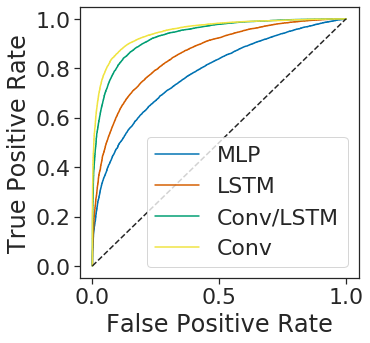

In [46]:
evaluate_model(cnn, 'Conv', X_test, y_test)

Finally we can try a more complicated network using the Keras functional API. This is a "deep residual" network made up of residual blocks. The residual blocks contain shortcut layers that allow the network to skip layers and pass information from the input into lower layers of the network without too much modification:

In [48]:
def residual_block(prev, num_channels, conv_type=None):
    # save a reference to the first layer so we can
    # create the shortcut...
    shortcut = prev

    # Perform two convolutions with a kernel size of 5
    prev = layers.Conv1D(num_channels,
                         kernel_size=5,
                         padding='same')(prev)
    prev = layers.BatchNormalization()(prev)
    prev = layers.Activation('relu')(prev)

    prev = layers.Conv1D(num_channels,
                         kernel_size=5,
                         padding='same')(prev)
    prev = layers.BatchNormalization()(prev)

    # This is the skip connection/shortcut layer which is
    # called on the first layer rather than the previous one
    shortcut = layers.Conv1D(num_channels,
                             kernel_size=1,
                             padding='same')(shortcut)
    shortcut = layers.BatchNormalization()(shortcut)

    # We can then merge the convolutions with the shortcut
    prev = layers.add([shortcut, prev])
    prev = layers.Activation('relu')(prev)
    return prev


def stack_convs(prev, num_channels, min_shape):
    convs = []
    while True:
        prev = residual_block(prev, num_channels)
        # stop stacking once layers have been downsampled so that the
        # tensor is only min_shape size in the spatial dimension 
        curr_shape = prev.shape.as_list()[1]
        if curr_shape <= min_shape:
            break
        convs.append(prev)
        prev = layers.MaxPool1D(2, padding='same')(prev)
    return prev


def build_resnet():
    # Functional API requires you to specify an input tensor and an output tensor
    # which 
    input_layer = layers.Input(shape=(128, 4))
    prev = stack_convs(input_layer, num_channels=8, min_shape=16)
    prev = layers.Flatten()(prev)
    prev = layers.Dense(16, activation='relu')(prev)
    prev = layers.Dropout(0.5)(prev)
    output_layer = layers.Dense(
        1, activation='sigmoid', name='binary_output')(prev)

    model = models.Model(input_layer, output_layer)
    model.compile(
        optimizer=optimizers.RMSprop(lr=1e-3),
        loss='binary_crossentropy'
    )
    return model

resnet = build_resnet()
resnet.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 128, 4)       0                                            
__________________________________________________________________________________________________
conv1d_24 (Conv1D)              (None, 128, 8)       168         input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_19 (BatchNo (None, 128, 8)       32          conv1d_24[0][0]                  
__________________________________________________________________________________________________
activation_12 (Activation)      (None, 128, 8)       0           batch_normalization_19[0][0]     
__________________________________________________________________________________________________
conv1d_26 

In [49]:
es = callbacks.EarlyStopping(min_delta=0.005, patience=5, verbose=1)
lrd = callbacks.ReduceLROnPlateau(
    min_delta=0.005, factor=0.1, patience=3, verbose=1)

resnet.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=100,
    batch_size=64,
    verbose=2,
    callbacks=[es, lrd]
)

Train on 68747 samples, validate on 7639 samples
Epoch 1/100
 - 22s - loss: 0.6276 - val_loss: 0.4283
Epoch 2/100
 - 18s - loss: 0.3794 - val_loss: 0.3144
Epoch 3/100
 - 19s - loss: 0.3199 - val_loss: 0.3949
Epoch 4/100
 - 19s - loss: 0.2892 - val_loss: 0.2536
Epoch 5/100
 - 19s - loss: 0.2691 - val_loss: 0.2443
Epoch 6/100
 - 18s - loss: 0.2605 - val_loss: 0.2473
Epoch 7/100
 - 17s - loss: 0.2533 - val_loss: 0.2373
Epoch 8/100
 - 18s - loss: 0.2468 - val_loss: 0.3000
Epoch 9/100
 - 19s - loss: 0.2428 - val_loss: 0.2637
Epoch 10/100
 - 17s - loss: 0.2402 - val_loss: 0.2903

Epoch 00010: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 11/100
 - 18s - loss: 0.2241 - val_loss: 0.2270
Epoch 12/100
 - 18s - loss: 0.2199 - val_loss: 0.2282
Epoch 13/100
 - 19s - loss: 0.2202 - val_loss: 0.2261
Epoch 14/100
 - 18s - loss: 0.2187 - val_loss: 0.2257

Epoch 00014: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Epoch 15/100
 - 17s - loss: 0.2164 - val

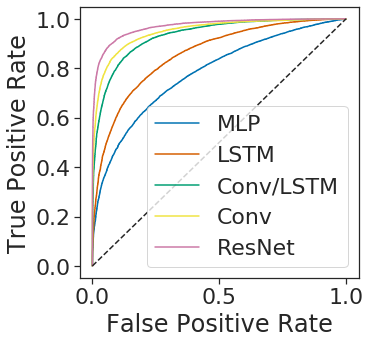

In [50]:
evaluate_model(resnet, 'ResNet', X_test, y_test)